In [2]:
!pip install tqdm
!pip install matplotlib
!pip install seaborn
!pip install pandas

  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import os
from typing import Optional

import numpy as np
import pandas as pd

#%tensorflow_version 1.x
import tensorflow as tf
from tqdm.auto import tqdm


/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from utils.plot import plot_image_by_band 
from batchers import dataset_constants
from batchers import tfrecord_paths_utils
import matplotlib.pyplot as plt
import numpy as np

In [5]:
REQUIRED_BANDS = [
    'BLUE', 'GREEN', 'LAT', 'LON', 'NIGHTLIGHTS', 'NIR', 'RED',
    'SWIR1', 'SWIR2', 'TEMP1']

BANDS_ORDER = [
    'BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR',
    'DMSP', 'VIIRS']

EXPORT_FOLDER = '../data/idhm_tfrecords_raw'

PROCESSED_FOLDER = '../data/idhm_tfrecords'

In [6]:
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
PROCESSED_DATA_DIR = '../data'
DATASET_NAME = 'IDHM'
MEANS = dataset_constants.MEANS_DICT[DATASET_NAME]
STD_DEVS = dataset_constants.STD_DEVS_DICT[DATASET_NAME]

In [7]:
def inspecting_single_file(tfrecord_path):
  options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)
  iterator = tf.io.tf_record_iterator(tfrecord_path, options=options)
  for record_str in iterator:
    # parse into an actual Example message
    ex = tf.train.Example.FromString(record_str)
    feature_map = ex.features.feature
  
    feature_types = {}
    for name in feature_map.keys():
      ft_type = feature_map[name].WhichOneof('kind')
      ft_shape = np.array(feature_map[name].__getattribute__(ft_type).value).shape
      feature_types[name] = (ft_type, ft_shape)

    return feature_map, feature_types

         

In [8]:
feature_map, feature_types = inspecting_single_file(tfrecord_paths_utils.idhm()[20])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Loc: (-24.681864, -48.963932), ADRIANOPOLIS, 2010


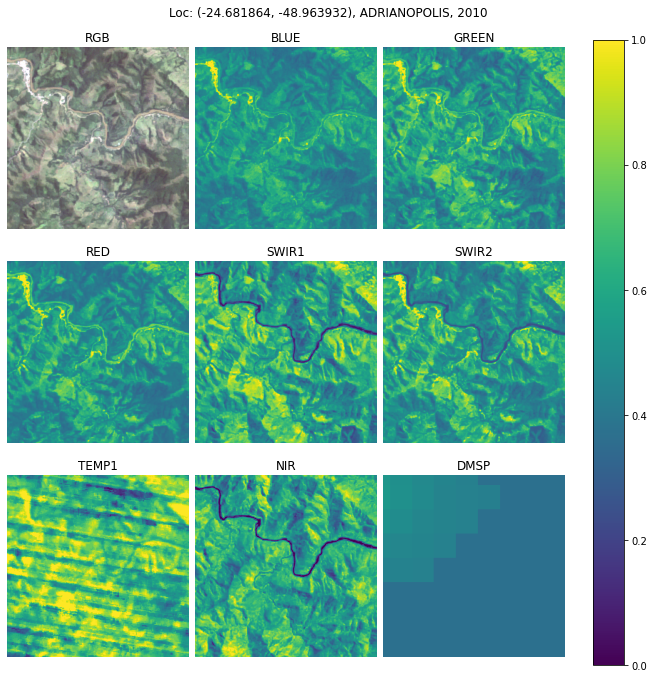

In [9]:
def year_to_nltype(year):
    return 'DMSP' if year < 2012 else 'VIIRS'

def band_keys_for_year(band_keys, year):
    '''
    Args
    - band_keys: list of str, including 'NIGHTLIGHTS'
    - year: numeric

    Returns
    - new_band_keys: copy of band_keys with 'NIGHTLIGHTS' replaced by 'DMSP' or 'VIIRS'
    '''
    new_band_keys = list(band_keys) # make a local copy
    new_band_keys[band_keys.index('NIGHTLIGHTS')] = year_to_nltype(year)
    return new_band_keys

def plot_single_img(feature_map):
    lat = np.float32(feature_map['lat'].float_list.value[0])
    lon = np.float32(feature_map['lon'].float_list.value[0])
    municipality = feature_map['municipality'].bytes_list.value[0].decode()
    year = int(feature_map['year'].float_list.value[0])
    fig_title = f'Loc: ({lat:.6f}, {lon:.6f}), {municipality}, {year}'
    print(fig_title)

    # choose 'DMSP' or 'VIIRS' for nightlights band name based on year
    band_keys_nl = band_keys_for_year(BAND_ORDER, year)

    img_normalized = []
    for b_idx, b_name in enumerate(BAND_ORDER):
        band = np.asarray(feature_map[b_name].float_list.value, dtype=np.float32).reshape(255, 255)
        b = band_keys_nl[b_idx]
        band = (band - MEANS[b]) / STD_DEVS[b]
        img_normalized.append(band)
    img_normalized = np.stack(img_normalized, axis=2)

    plot_image_by_band(img=img_normalized, band_order=band_keys_nl, nrows=3, title=fig_title,
                       rgb='add', colorbar=True)

plot_single_img(feature_map)

In [10]:
columns = list(feature_types.keys())
columns

['IncomeIDHM',
 'IDHL-Sector',
 'SWIR2',
 'year',
 'BLUE',
 'RED',
 'SWIR1',
 'NIR',
 'type',
 'lon',
 'municipality',
 'lat',
 'NIGHTLIGHTS',
 'GREEN',
 'LAT',
 'state',
 'system:index',
 'LON',
 'TEMP1',
 'AlfabIDHM']

In [11]:
data = {col: [None]  for col in columns}

In [12]:
df = pd.DataFrame(data, columns=columns)
df = df.tail(df.shape[0] -1)
df

,IncomeIDHM,IDHL-Sector,SWIR2,year,BLUE,RED,SWIR1,NIR,type,lon,municipality,lat,NIGHTLIGHTS,GREEN,LAT,state,system:index,LON,TEMP1,AlfabIDHM


In [13]:
from PIL import Image

In [14]:
df_vr = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'vr_clusters_with_code.csv'))
df_vr

,state,year,municipality,type,lon,lat,Cod_setor,IDHL-Sector,AlfabIDHM,IncomeIDHM
0,PR,2010,ADRIANOPOLIS,URBANO,-48.992090,-24.661447,410020205000001,0.733333,0.965732,0.631374
1,PR,2010,ADRIANOPOLIS,URBANO,-48.990989,-24.659564,410020205000002,0.766667,0.980271,0.656986
2,PR,2010,ADRIANOPOLIS,RURAL,-48.972301,-24.729386,410020205000003,0.833333,0.903872,0.536900
3,PR,2010,ADRIANOPOLIS,RURAL,-48.917691,-24.727783,410020205000004,0.800000,0.945604,0.512003
4,PR,2010,ADRIANOPOLIS,RURAL,-48.920161,-24.680383,410020205000005,0.900000,0.962963,0.563248
...,...,...,...,...,...,...,...,...,...,...
875,SP,2010,TAPIRAI,RURAL,-47.581614,-23.910936,355350005000012,0.766667,0.963391,0.529998
876,SP,2010,TAPIRAI,RURAL,-47.564317,-23.880609,355350005000013,0.850000,0.940125,0.493536
877,SP,2010,TAPIRAI,RURAL,-47.585273,-24.039135,355350005000014,0.766667,0.885705,0.494162
878,SP,2010,TAPIRAI,URBANO,-47.506802,-23.963692,355350005000015,0.933333,0.983333,0.643150


In [15]:
df_vr1 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'VR_clusters.csv'), sep=';')
df_vr1

,Unnamed: 0,Cod_setor,lat,long,TIPO,income,longevity,literacy,population
0,0,350270505000001,-48.848982,-24.513062,URBANO,0.606203,0.800000,0.970194,521.0
1,1,350270505000002,-48.846967,-24.511579,URBANO,0.671455,0.850000,0.971920,452.0
2,2,350270505000003,-48.845093,-24.514756,URBANO,0.778504,0.933333,0.975673,299.0
3,3,350270505000004,-48.846954,-24.519240,URBANO,0.808376,0.800000,0.939745,358.0
4,4,350270505000005,-48.841910,-24.522869,URBANO,0.545806,0.816667,0.968134,837.0
...,...,...,...,...,...,...,...,...,...
875,875,412863305000009,-49.350120,-24.719030,RURAL,0.400798,0.750000,0.902424,546.0
876,876,412863305000010,-49.384792,-24.660716,RURAL,0.449906,0.783333,0.900085,570.0
877,877,412863305000011,-49.441333,-24.676312,RURAL,0.461763,0.783333,0.936782,341.0
878,878,412863305000012,-49.493091,-24.678702,RURAL,0.428022,0.750000,0.885842,451.0


In [16]:
for i  in range(880):
    print(i)
    feature_map, feature_types = inspecting_single_file(tfrecord_paths_utils.idhm()[i])
    # Create a new row for the DataFrame with the standard feature data
    new_row = {}
    new_row['LAT'] = np.float32(feature_map['lat'].float_list.value[0])
    new_row['LON'] = np.float32(feature_map['lon'].float_list.value[0])
    new_row['municipality'] = feature_map['municipality'].bytes_list.value[0].decode()
    year = int(feature_map['year'].float_list.value[0])
    new_row['year'] = year
    new_row['type'] = feature_map['type'].bytes_list.value[0].decode()
    new_row['state'] = feature_map['state'].bytes_list.value[0].decode()
    new_row['AlfabIDHM'] = np.float32(feature_map['AlfabIDHM'].float_list.value[0])
    new_row['IncomeIDHM'] = np.float32(feature_map['AlfabIDHM'].float_list.value[0])
    new_row['IDHL-Sector'] = np.float32(feature_map['AlfabIDHM'].float_list.value[0])
    
    
# choose 'DMSP' or 'VIIRS' for nightlights band name based on year
    band_keys_nl = band_keys_for_year(BAND_ORDER, year)

    #img_normalized = []
    for b_idx, b_name in enumerate(BAND_ORDER):
        band = np.asarray(feature_map[b_name].float_list.value, dtype=np.float32).reshape(255, 255)
        b = band_keys_nl[b_idx]
        band = (band - MEANS[b]) / STD_DEVS[b]
        
        new_row[b_name] = np.clip(band / 6.0 + 0.5, a_min=0, a_max=1)
        im = Image.fromarray((np.stack([new_row[b_name],new_row[b_name],new_row[b_name]], axis=2) * 255).astype(np.uint8))
        img = im.resize((224, 224))
        new_row[b_name+'_img'] = img
    r, g, b = new_row['RED'], new_row['GREEN'], new_row['BLUE']
    new_row['RGB'] = np.stack([r,g,b], axis=2)
    im = Image.fromarray((new_row['RGB'] * 255).astype(np.uint8))
    img = im.resize((224, 224))
    new_row['RGB_img'] = img
    
    df = df.append(new_row, ignore_index=True)
#plot_image_by_band(img=img_normalized, band_order=band_keys_nl, nrows=3, title=fig_title,
#                       rgb='add', colorbar=True)
        
        
# def plot_image_by_band(img, band_order, nrows, title, rgb=None, colorbar=False):       
    '''
    Args
    - img: np.array, shape [H, W, C], type float, normalized
    - band_order: list of str, names of the bands in order
    - nrows: int, desired number of rows in the created figure
    - title: str, or None
    - rgb: one of [None, 'merge', 'add']
        - None: do not create a separate RGB image
        - 'merge': plot the RGB bands as a merged image
        - 'add': plot all bands, but also add a merged RGB image
    - colorbar: bool, whether to show colorbar
    '''
'''
    nbands = img.shape[2]
    rgb_to_naxs = {
        None: nbands,
        'merge': nbands - 2,
        'add': nbands + 1
    }
    nplots = rgb_to_naxs[rgb]
    ncols = int(np.ceil(nplots / float(nrows)))
    fig_w = min(15, 3*ncols)
    fig_h = min(15, 3*nrows)
    fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                            figsize=[fig_w, fig_h], constrained_layout=True)
    if title is not None:
        fig.suptitle(title, y=1.03)

    # scale image to [0,1]: 0 = -3 std, 0.5 = mean, 1 = +3 std
    scaled_img = np.clip(img / 6.0 + 0.5, a_min=0, a_max=1)
    bands = {band_name: scaled_img[:, :, b] for b, band_name in enumerate(band_order)}

    plots = []
    plot_titles = []
    if rgb is not None:
        r, g, b = bands['RED'], bands['GREEN'], bands['BLUE']
        rgb_img = np.stack([r,g,b], axis=2)
        plots.append(rgb_img)
        plot_titles.append('RGB')

    if rgb == 'merge':
        for band_name in band_order:
            if band_name not in ['RED', 'GREEN', 'BLUE']:
                plots.append(bands[band_name])
                plot_titles.append(band_name)
    else:
        plots += [bands[band_name] for band_name in band_order]
        plot_titles += band_order

    for b in range(len(plots)):
        if len(axs.shape) == 1:
            ax = axs[b]
        else:
            ax = axs[b // ncols, b % ncols]
        # set origin='lower' to match lat/lon direction
        im = ax.imshow(plots[b], origin='lower', cmap='viridis', vmin=0, vmax=1)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(plot_titles[b])

    if colorbar:
        fig.colorbar(im, orientation='vertical', ax=axs)
    plt.show()        
'''   

   #img_normalized.append(band)
    #img_normalized = np.stack(img_normalized, axis=2)
    
    
    #for feature in feature_types.keys():
        #new_row[feature] = feature_types[feature]
           
        
        
    #    print(feature)
    #    print(feature_types[feature][0])
    #    print(feature_types[feature][1][0])
    #    if feature_types[feature][0] == 'bytes_list':
    #        if feature_types[feature][1][0] > 1:
    #            byte_value = feature_map[feature].bytes_list.value[0].decode()
    #            print(byte_value)
    #            new_row[feature] = [val.decode() for val in byte_value]
    #        else:
    #            print(feature_map[feature].bytes_list.value[0])
    #            new_row[feature] = feature_map[feature].bytes_list.value[0]
    #    else:
    #        if feature_types[feature][1][0] > 1:
    #            new_row[feature] = feature_map[feature].float_list.value                        
    #        else:
    #            new_row[feature] = feature_map[feature].float_list.value[0]
    
    # Append the new row to the DataFrame

    
# Print the DataFrame with the filled data
#print(df.head())
df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,IncomeIDHM,IDHL-Sector,SWIR2,year,BLUE,RED,SWIR1,NIR,type,lon,...,BLUE_img,GREEN_img,NIGHTLIGHTS_img,NIR_img,RED_img,RGB,RGB_img,SWIR1_img,SWIR2_img,TEMP1_img
0,0.965732,0.965732,"[[0.39140376, 0.39776504, 0.44276518, 0.442765...",2010,"[[0.3861292, 0.41088268, 0.40390092, 0.4039009...","[[0.41699472, 0.43152252, 0.4564273, 0.4564273...","[[0.35163516, 0.37564304, 0.4503341, 0.4503341...","[[0.34074748, 0.38470694, 0.47212633, 0.472126...",URBANO,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.41699472, 0.41814741, 0.3861292], [0.4315...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...
1,0.980271,0.980271,"[[0.549022, 0.51886487, 0.49082816, 0.48988572...",2010,"[[0.46419787, 0.43055853, 0.43309736, 0.420403...","[[0.488596, 0.45020112, 0.41907012, 0.41561112...","[[0.6430637, 0.6022171, 0.5705401, 0.58071005,...","[[0.7496204, 0.73288584, 0.70703465, 0.6999162...",URBANO,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.488596, 0.52211744, 0.46419787], [0.45020...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...
2,0.903872,0.903872,"[[0.38951895, 0.36972833, 0.32142973, 0.374440...",2010,"[[0.36327985, 0.3569328, 0.35248983, 0.3816862...","[[0.38378832, 0.37963754, 0.36510974, 0.402466...","[[0.329628, 0.3176241, 0.24526712, 0.3491344, ...","[[0.4394065, 0.4059374, 0.36934614, 0.519083, ...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.38378832, 0.31992888, 0.36327985], [0.379...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...
3,0.945604,0.945604,"[[0.62229455, 0.6998078, 0.6797816, 0.65975535...",2010,"[[0.55876887, 0.5733671, 0.5308419, 0.5892347,...","[[0.56158084, 0.55535465, 0.55500877, 0.583718...","[[0.5957149, 0.6917463, 0.7187551, 0.7217561, ...","[[0.50159913, 0.5321959, 0.6890512, 0.6016319,...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.56158084, 0.55706906, 0.55876887], [0.555...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...
4,0.962963,0.962963,"[[0.6972162, 0.56692785, 0.62465054, 0.582242,...",2010,"[[0.6241435, 0.55686474, 0.5676548, 0.5333807,...","[[0.6812622, 0.5691907, 0.67296064, 0.56088907...","[[0.6609029, 0.5880457, 0.6202229, 0.50468516,...","[[0.55829686, 0.49747792, 0.43565995, 0.328259...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.6812622, 0.69864535, 0.6241435], [0.56919...",<PIL.Image.Image image mode=RGB s

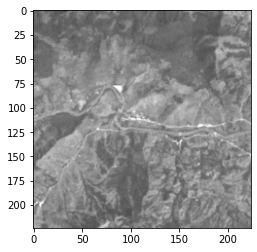

In [17]:
plt.imshow(df['BLUE_img'].iloc[6])

In [18]:
df

,IncomeIDHM,IDHL-Sector,SWIR2,year,BLUE,RED,SWIR1,NIR,type,lon,...,BLUE_img,GREEN_img,NIGHTLIGHTS_img,NIR_img,RED_img,RGB,RGB_img,SWIR1_img,SWIR2_img,TEMP1_img
0,0.965732,0.965732,"[[0.39140376, 0.39776504, 0.44276518, 0.442765...",2010,"[[0.3861292, 0.41088268, 0.40390092, 0.4039009...","[[0.41699472, 0.43152252, 0.4564273, 0.4564273...","[[0.35163516, 0.37564304, 0.4503341, 0.4503341...","[[0.34074748, 0.38470694, 0.47212633, 0.472126...",URBANO,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.41699472, 0.41814741, 0.3861292], [0.4315...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...
1,0.980271,0.980271,"[[0.549022, 0.51886487, 0.49082816, 0.48988572...",2010,"[[0.46419787, 0.43055853, 0.43309736, 0.420403...","[[0.488596, 0.45020112, 0.41907012, 0.41561112...","[[0.6430637, 0.6022171, 0.5705401, 0.58071005,...","[[0.7496204, 0.73288584, 0.70703465, 0.6999162...",URBANO,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.488596, 0.52211744, 0.46419787], [0.45020...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...
2,0.903872,0.903872,"[[0.38951895, 0.36972833, 0.32142973, 0.374440...",2010,"[[0.36327985, 0.3569328, 0.35248983, 0.3816862...","[[0.38378832, 0.37963754, 0.36510974, 0.402466...","[[0.329628, 0.3176241, 0.24526712, 0.3491344, ...","[[0.4394065, 0.4059374, 0.36934614, 0.519083, ...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.38378832, 0.31992888, 0.36327985], [0.379...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...
3,0.945604,0.945604,"[[0.62229455, 0.6998078, 0.6797816, 0.65975535...",2010,"[[0.55876887, 0.5733671, 0.5308419, 0.5892347,...","[[0.56158084, 0.55535465, 0.55500877, 0.583718...","[[0.5957149, 0.6917463, 0.7187551, 0.7217561, ...","[[0.50159913, 0.5321959, 0.6890512, 0.6016319,...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.56158084, 0.55706906, 0.55876887], [0.555...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...
4,0.962963,0.962963,"[[0.6972162, 0.56692785, 0.62465054, 0.582242,...",2010,"[[0.6241435, 0.55686474, 0.5676548, 0.5333807,...","[[0.6812622, 0.5691907, 0.67296064, 0.56088907...","[[0.6609029, 0.5880457, 0.6202229, 0.50468516,...","[[0.55829686, 0.49747792, 0.43565995, 0.328259...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.6812622, 0.69864535, 0.6241435], [0.56919...",<PIL.Image.Image image mode=RGB s

In [19]:
df['LAT'] = round(df['LAT'],3)
df['LON'] =  round(df['LON'],3)
df_vr['lat'] =  round(df_vr['lat'],3)
df_vr['lon'] =  round(df_vr['lon'],3)

In [20]:
df_geo_sat = df.merge(df_vr[['lat', 'lon', 'Cod_setor']], left_on=['LAT', 'LON'], right_on=['lat', 'lon'] ,how='left')
df_geo_sat

,IncomeIDHM,IDHL-Sector,SWIR2,year,BLUE,RED,SWIR1,NIR,type,lon_x,...,NIR_img,RED_img,RGB,RGB_img,SWIR1_img,SWIR2_img,TEMP1_img,lat_y,lon_y,Cod_setor
0,0.965732,0.965732,"[[0.39140376, 0.39776504, 0.44276518, 0.442765...",2010,"[[0.3861292, 0.41088268, 0.40390092, 0.4039009...","[[0.41699472, 0.43152252, 0.4564273, 0.4564273...","[[0.35163516, 0.37564304, 0.4503341, 0.4503341...","[[0.34074748, 0.38470694, 0.47212633, 0.472126...",URBANO,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.41699472, 0.41814741, 0.3861292], [0.4315...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,-24.661,-48.992,410020205000001
1,0.980271,0.980271,"[[0.549022, 0.51886487, 0.49082816, 0.48988572...",2010,"[[0.46419787, 0.43055853, 0.43309736, 0.420403...","[[0.488596, 0.45020112, 0.41907012, 0.41561112...","[[0.6430637, 0.6022171, 0.5705401, 0.58071005,...","[[0.7496204, 0.73288584, 0.70703465, 0.6999162...",URBANO,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.488596, 0.52211744, 0.46419787], [0.45020...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,-24.660,-48.991,410020205000002
2,0.903872,0.903872,"[[0.38951895, 0.36972833, 0.32142973, 0.374440...",2010,"[[0.36327985, 0.3569328, 0.35248983, 0.3816862...","[[0.38378832, 0.37963754, 0.36510974, 0.402466...","[[0.329628, 0.3176241, 0.24526712, 0.3491344, ...","[[0.4394065, 0.4059374, 0.36934614, 0.519083, ...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.38378832, 0.31992888, 0.36327985], [0.379...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,-24.729,-48.972,410020205000003
3,0.945604,0.945604,"[[0.62229455, 0.6998078, 0.6797816, 0.65975535...",2010,"[[0.55876887, 0.5733671, 0.5308419, 0.5892347,...","[[0.56158084, 0.55535465, 0.55500877, 0.583718...","[[0.5957149, 0.6917463, 0.7187551, 0.7217561, ...","[[0.50159913, 0.5321959, 0.6890512, 0.6016319,...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.56158084, 0.55706906, 0.55876887], [0.555...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,-24.728,-48.918,410020205000004
4,0.962963,0.962963,"[[0.6972162, 0.56692785, 0.62465054, 0.582242,...",2010,"[[0.6241435, 0.55686474, 0.5676548, 0.5333807,...","[[0.6812622, 0.5691907, 0.67296064, 0.56088907...","[[0.6609029, 0.5880457, 0.6202229, 0.50468516,...","[[0.55829686, 0.49747792, 0.43565995, 0.328259...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[[[0.6812622, 0.69864535, 0.6241435], [0.56919...",<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,<PIL.Image.Image image mode=RGB size=224x224 a...,-24.680,-48.920,410020205000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,0.902234,0.902234,"[[0.45572335, 0.44182277, 0.44182277, 0.463498...",2010,"[[0.39247626, 0.40643975, 0.40643975, 0.403900...","[[0.39312762, 0.41007674, 0.41007674, 0.425296...","[[0.4474998, 0.39298204, 0.39298204, 0.4476665...","[[0.35361063, 0.35885584, 0.35885584, 0.429665...",RURAL,NaN,...,<PIL.Image.Image image mode=RGB size=224x224 

In [21]:
df_geo_sat1 = df_geo_sat.merge(df_vr1, on='Cod_setor', how='left')
df_geo_sat1

,IncomeIDHM,IDHL-Sector,SWIR2,year,BLUE,RED,SWIR1,NIR,type,lon_x,...,lon_y,Cod_setor,Unnamed: 0,lat,long,TIPO,income,longevity,literacy,population
0,0.965732,0.965732,"[[0.39140376, 0.39776504, 0.44276518, 0.442765...",2010,"[[0.3861292, 0.41088268, 0.40390092, 0.4039009...","[[0.41699472, 0.43152252, 0.4564273, 0.4564273...","[[0.35163516, 0.37564304, 0.4503341, 0.4503341...","[[0.34074748, 0.38470694, 0.47212633, 0.472126...",URBANO,NaN,...,-48.992,410020205000001,679,-48.992090,-24.661447,URBANO,0.631374,0.733333,0.965732,457.0
1,0.980271,0.980271,"[[0.549022, 0.51886487, 0.49082816, 0.48988572...",2010,"[[0.46419787, 0.43055853, 0.43309736, 0.420403...","[[0.488596, 0.45020112, 0.41907012, 0.41561112...","[[0.6430637, 0.6022171, 0.5705401, 0.58071005,...","[[0.7496204, 0.73288584, 0.70703465, 0.6999162...",URBANO,NaN,...,-48.991,410020205000002,680,-48.990989,-24.659564,URBANO,0.656986,0.766667,0.980271,607.0
2,0.903872,0.903872,"[[0.38951895, 0.36972833, 0.32142973, 0.374440...",2010,"[[0.36327985, 0.3569328, 0.35248983, 0.3816862...","[[0.38378832, 0.37963754, 0.36510974, 0.402466...","[[0.329628, 0.3176241, 0.24526712, 0.3491344, ...","[[0.4394065, 0.4059374, 0.36934614, 0.519083, ...",RURAL,NaN,...,-48.972,410020205000003,681,-48.972301,-24.729386,RURAL,0.536900,0.833333,0.903872,461.0
3,0.945604,0.945604,"[[0.62229455, 0.6998078, 0.6797816, 0.65975535...",2010,"[[0.55876887, 0.5733671, 0.5308419, 0.5892347,...","[[0.56158084, 0.55535465, 0.55500877, 0.583718...","[[0.5957149, 0.6917463, 0.7187551, 0.7217561, ...","[[0.50159913, 0.5321959, 0.6890512, 0.6016319,...",RURAL,NaN,...,-48.918,410020205000004,682,-48.917691,-24.727783,RURAL,0.512003,0.800000,0.945604,594.0
4,0.962963,0.962963,"[[0.6972162, 0.56692785, 0.62465054, 0.582242,...",2010,"[[0.6241435, 0.55686474, 0.5676548, 0.5333807,...","[[0.6812622, 0.5691907, 0.67296064, 0.56088907...","[[0.6609029, 0.5880457, 0.6202229, 0.50468516,...","[[0.55829686, 0.49747792, 0.43565995, 0.328259...",RURAL,NaN,...,-48.920,410020205000005,683,-48.920161,-24.680383,RURAL,0.563248,0.900000,0.962963,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,0.902234,0.902234,"[[0.45572335, 0.44182277, 0.44182277, 0.463498...",2010,"[[0.39247626, 0.40643975, 0.40643975, 0.403900...","[[0.39312762, 0.41007674, 0.41007674, 0.425296...","[[0.4474998, 0.39298204, 0.39298204, 0.4476665...","[[0.35361063, 0.35885584, 0.35885584, 0.429665...",RURAL,NaN,...,-48.872,412788205000008,862,-48.872190,-24.990672,RURAL,0.380688,0.800000,0.902234,247.0
876,0.416510,0.416510,"[[0.37538278, 0.43145624, 0.43145624, 0.431456...",2010,"[[0.4000927, 0.41151738, 0.41151738, 0.4115173...","[[0.38724732, 0.41907012, 0.4135357, 0.4135357...","[[0.3763099, 0.41365546, 0.4573364, 0.4573364,...","[[0.5617936, 0.47812083, 0.5188333, 0.5188333,...",RURAL,NaN,...,-48.852,412788205000009,863,-48.852456,-24.905027,RURAL,0.510546,0.616667,0.416510,72.0
877,0.742297,0.742297,"[[0.42533058, 0.43569708, 0.4517181, 0.4538385...",2010,"[[0.38866803, 0.39247626, 0.38993743, 0.388668...","[[0.37341136, 0.40108332, 0.40177512, 0.400045...","[[0.42866033, 0.4583367, 0.48067737, 0.4771762...","[[0.4281669, 0.48886093, 0.52045673, 0.4941060...",RURAL,NaN,...,-48.762,412788205000010,864,-48.762314,-24.958559,RURAL,0.462397,0.766667,0.742297,171.0
878,0.853725,0.853725,"[[0.4022415, 0.37396917, 0.3701995, 0.38386446...",2010,"[[0.40263152, 0.36835748, 0.36645335, 0.367722...","[[0.38448012, 0.37341136, 0.37894574, 0.383788...","[[0.39531612, 0.32529324, 0.32862765, 0.348800...","[[0.3689715, 0.28192675, 0.2813024, 0.30428118...",URBANO,NaN,...,-49.091,412788205000011,865,-49.090760,-24.977358,URBANO,0.556493,0.683333,0.853725,538.0


In [22]:
df_geo_sat1['Cod_setor'].nunique()

880

In [23]:
df_geo_sat1[df_geo_sat1['population'].isna()]

,IncomeIDHM,IDHL-Sector,SWIR2,year,BLUE,RED,SWIR1,NIR,type,lon_x,...,lon_y,Cod_setor,Unnamed: 0,lat,long,TIPO,income,longevity,literacy,population


In [24]:
OUT_FILE = 'df_satelite.csv'

In [25]:
df_geo_sat1.to_csv(OUT_FILE, mode='a', index=None)

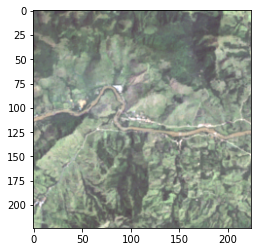

In [26]:
plt.imshow(df['RGB_img'].iloc[6])

In [27]:
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

In [28]:
batch_img = []
records = []
for index, row in df_geo_sat1.iterrows():
    for b_idx, b_name in enumerate(BAND_ORDER):
        print([df_geo_sat1['Cod_setor'].loc[index],b_name])
        records.append([df_geo_sat1['Cod_setor'].loc[index],b_name, df_geo_sat1['income'].loc[index], df_geo_sat1['literacy'].loc[index], df_geo_sat1['longevity'].loc[index], df_geo_sat1['population'].loc[index], df_geo_sat1['TIPO'].loc[index]]) #inputs to VGG are images of 224x224)
    #img = image.load_img(df['img'].loc[index], target_size=(224, 224))#inputs to VGG are images of 224x224
        x = image.img_to_array(df_geo_sat1[b_name+'_img'].loc[index])
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x) #<class 'numpy.ndarray'> (1, 224, 224, 3) 
        batch_img.append(x)
    records.append([df_geo_sat1['Cod_setor'].loc[index],'RGB', df_geo_sat1['income'].loc[index], df_geo_sat1['literacy'].loc[index], df_geo_sat1['longevity'].loc[index], df_geo_sat1['population'].loc[index], df_geo_sat1['TIPO'].loc[index]]) #inputs to VGG are images of 224x224)
    #img = image.load_img(df['img'].loc[index], target_size=(224, 224))#inputs to VGG are images of 224x224
    x = image.img_to_array(df_geo_sat1['RGB_img'].loc[index])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) #<class 'numpy.ndarray'> (1, 224, 224, 3) 
    batch_img.append(x)
    #print(df['img'].loc[index])
#    if index >= 1000:
#        break


[410020205000001, 'BLUE']
[410020205000001, 'GREEN']
[410020205000001, 'RED']
[410020205000001, 'SWIR1']
[410020205000001, 'SWIR2']
[410020205000001, 'TEMP1']
[410020205000001, 'NIR']
[410020205000001, 'NIGHTLIGHTS']
[410020205000002, 'BLUE']
[410020205000002, 'GREEN']
[410020205000002, 'RED']
[410020205000002, 'SWIR1']
[410020205000002, 'SWIR2']
[410020205000002, 'TEMP1']
[410020205000002, 'NIR']
[410020205000002, 'NIGHTLIGHTS']
[410020205000003, 'BLUE']
[410020205000003, 'GREEN']
[410020205000003, 'RED']
[410020205000003, 'SWIR1']
[410020205000003, 'SWIR2']
[410020205000003, 'TEMP1']
[410020205000003, 'NIR']
[410020205000003, 'NIGHTLIGHTS']
[410020205000004, 'BLUE']
[410020205000004, 'GREEN']
[410020205000004, 'RED']
[410020205000004, 'SWIR1']
[410020205000004, 'SWIR2']
[410020205000004, 'TEMP1']
[410020205000004, 'NIR']
[410020205000004, 'NIGHTLIGHTS']
[410020205000005, 'BLUE']
[410020205000005, 'GREEN']
[410020205000005, 'RED']
[410020205000005, 'SWIR1']
[410020205000005, 'SWIR2']


In [29]:
a = 1

In [36]:
OUT_FILE   = 'df_vgg_features_satelite.csv'

In [37]:
base_model = VGG16(weights='imagenet')

In [38]:
model = Model(inputs=base_model.input,
            outputs=base_model.get_layer('fc2').output)#fc2:fully-connected-2

In [39]:
if len(batch_img) >= 0:
    batch_img_arr = np.concatenate(batch_img, axis=0) #(800, 224, 224, 3)
    latent = model.predict(batch_img_arr) #latent space <class 'numpy.ndarray'>, (800, 4096)
    data = pd.concat([
        pd.DataFrame.from_records(records),
        pd.DataFrame(latent)
        ], axis=1)
    data.to_csv(OUT_FILE, header=None, mode='a', index=None)


In [40]:
a = 2

In [35]:
a= 3